### QUICKSTART GUIDE

First start with instructions in https://github.com/tensor4all/xfac

First get the package:

git clone https://github.com/tensor4all/xfac.git
cd xfac

Now activate the conda environment you want your python to use. 

conda activate zplasma

Next, install using this environment variables, the second step might need sudo

cmake -S . -B build       -D CMAKE_BUILD_TYPE=Release       -D XFAC_BUILD_PYTHON=ON       -D PYTHON_EXECUTABLE=$(which python) -D CMAKE_INSTALL_PREFIX=$CONDA_PREFIX
cmake --build build -j4    

Now, lastly, use 

find  -name "xfacpy*.so"

This grabs for example "./build/python/xfacpy.cpython-310-x86_64-linux-gnu.so", check it is the right version for that environment
Then move it to the right place!

cp build/python/xfacpy.cpython-310-x86_64-linux-gnu.so /home/zach/anaconda3/envs/zplasma/lib/python3.10/site-packages/

### Initial Tests xfacpy

see https://xfac.readthedocs.io/en/latest/tutorial-python/quantics1d.html

In [1]:
import xfacpy

from liquids.python.qtt_core.qtt_util import *
import tt as ttpy
import numpy as np
from math import cos, sin, exp, sqrt, log, atan
import matplotlib.pyplot as plt

In [2]:
Γ, κ = 100, 3
n0 = 3/(4*π)

rcut = lambda r: 1e-6 + r
βu_r_func = lambda r: Γ/rcut(r)*np.exp(-κ*rcut(r))
f_M_r_func = lambda r: np.exp(-βu_r_func(r))-1

N_bits = 10
N_grid = 2**N_bits
print(f"N_points = {N_grid}")
R_max = 100

N_points = 1024


In [3]:
def make_qtt_with_TCI(func, r_min, r_max, N_bits, max_bond_dimension, plot_pivot_error=True):
    def f_caching(x): 
        y = func(x)
        f_caching.sampled[x] = y    
        return y
    f_caching.sampled = {}
    qgrid = xfacpy.QuanticsGrid(a=r_min, b=r_max, nBit=N_bits)  # build the quantics grid
    args = xfacpy.TensorCI2Param()                      # fix the max bond dimension
    args.bondDim = max_bond_dimension
    f_ci = xfacpy.QTensorCI(f1d=f_caching, qgrid=qgrid, args=args)  # construct a tci of the quantics tensor
    while not f_ci.isDone():
        f_ci.iterate()
    qtt = f_ci.get_qtt() 
    
    if plot_pivot_error:
        print("Cores: ", [core.shape for core in qtt.tt.core])
        plt.xlabel("rank")
        plt.ylabel("pivot error")
        plt.yscale("log")
        plt.plot(f_ci.pivotError,'--.');
    
    return qtt

Cores:  [(1, 2, 2), (2, 2, 4), (4, 2, 3), (3, 2, 2), (2, 2, 2), (2, 2, 1), (1, 2, 1), (1, 2, 1), (1, 2, 1), (1, 2, 1)]


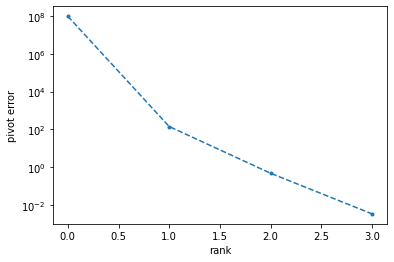

In [4]:
βu_r_xfac_qtt = make_qtt_with_TCI(βu_r_func, 0, R_max, N_bits, 20)

Cores:  [(1, 2, 2), (2, 2, 4), (4, 2, 7), (7, 2, 5), (5, 2, 3), (3, 2, 2), (2, 2, 1), (1, 2, 1), (1, 2, 1), (1, 2, 1)]


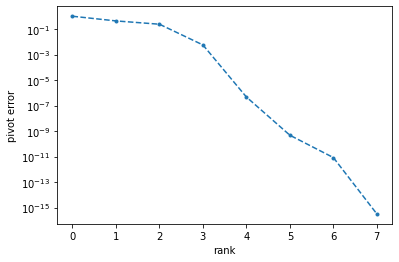

In [5]:
f_M_r_xfac_qtt = make_qtt_with_TCI(f_M_r_func, 0, R_max, N_bits, 10)

(1e-12, 2.0177529534165548e+16)

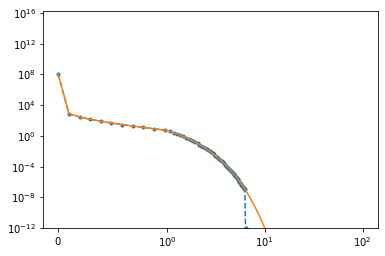

In [18]:
def xfac_qtt_to_ttpy_qtt(xfac_qtt):
    core_list = xfac_qtt.core
    return ttpy.vector.from_list(core_list)

βu_r_grid = binarytensor_to_tensor(xfac_qtt_to_ttpy_qtt(βu_r_xfac_qtt.tt).full(), order='F')
fig, ax = plt.subplots()

r_tmp_array = np.linspace(0,R_max, N_grid)
ax.plot(r_tmp_array, βu_r_grid, '--.')
ax.plot(r_tmp_array, βu_r_func(r_tmp_array))
ax.set_xscale("symlog", linthresh=1)
ax.set_yscale("log")
ax.set_ylim(1e-12,None)

In [15]:
np.max(βu_r_grid)/1e4

9999.970000045